# 0.9 Pytorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.


## Resources:

* Book version of notebook:https://www.learnpytorch.io/09_pytorch_model_deployment/

* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf

## 0. Get setup

In [ ]:
import torch
import torchvision

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset(pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directories
train_dir = data_20_percent_path/"train"
test_dir = data_20_percent_path/"test"

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

1. Perfoms well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+, or 30ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 0.7 PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 0.8 PyTorch Paper Replicating)



## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

In [ ]:
import torchvision

# 1. Setup the pretrained weights
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get pretrained transforms
effnet_b2_transforms = effnet_b2_weights.transforms()

# 3. Create the pretrained model instance
effnet_b2_model = torchvision.models.efficientnet_b2(weights = effnet_b2_weights)

# 4. Freeze the base layer
for param in effnet_b2_model.parameters():
  param.requires_grad = False

#print(effnet_b2_model.classifier) # uncomment to check the classifier data

# 5. Update the classifier head to suit our data
effnet_b2_model.classifier =nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 124MB/s]


### 3.1 Creating a function to make an EffNetB2 feature extractor

In [3]:
def create_effnet_b2_model(num_classes: int = 3,
                           seed: int = 42):
  """
  Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.

  """

  # 1. Setup pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2.Get transforms
  transforms = weights.transforms()

  # 3. Cretate the pretrained model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the base layer
  for param in model.parameters():
    param.requires_grad = False

  # 5. Update the classifier head to suit our data with reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features= num_classes)
  )

  return model, transforms

In [ ]:
effnet_b2, effnetb2_transforms = create_effnet_b2_model()
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
#effnet_b2

### 3.2 Create Dataloaders for EffNetB2

In [ ]:
from going_modular.going_modular import data_setup

# Create dataloaders
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                                                   test_dir = test_dir,
                                                                                                   transform = effnet_b2_transforms,
                                                                                                   batch_size = 32)

### 3.3 Training the EffNetB2 feature extractor

In [ ]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params = effnet_b2.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from going_modular.going_modular import engine

set_seeds()

# Train the model
effnetb2_results = engine.train(model=effnet_b2,
                                train_dataloader = train_dataloader_effnet_b2,
                                test_dataloader = test_dataloader_effnet_b2,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

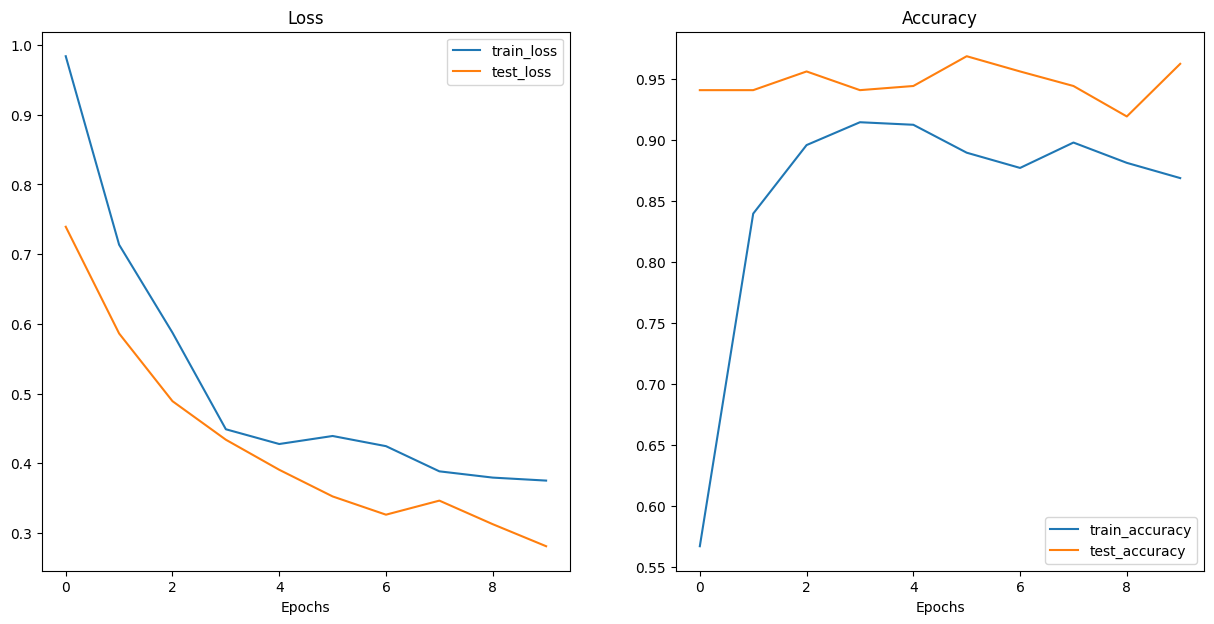

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save  the model
utils.save_model(model = effnet_b2,
                 target_dir = "models",
                 model_name = "09_pretrained_effnetb2_feature_extractor_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

Why whould it be important to consider the size of a saved model?

If we're deployuing our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert it to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_steak_sushi_20_percent.pth").stat().st_size/(1024*1024)
print(f"Pretrained EffNetB2 model size:{pretrained_effnetb2_model_size:.3f} MB")


Pretrained EffNetB2 model size:29.861 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(params) for params in effnet_b2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss":effnetb2_results["test_loss"][-1],
                  "test_acc":effnetb2_results["test_acc"][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model_size (MB)":pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8607120513916}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, reapeating the steps for EffNetB2 but this time with a ViT feature extractor

In [ ]:
# Check out ViT head layer
vit_heads = torchvision.models.vit_b_16()
vit_heads.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes: int = 3,
                           seed: int = 42):
  """
  Creates an ViT feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT feature extractor model.
        transforms (torchvision.transforms): ViT image transforms.

  """

  # 1. Setup pretrained weights
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2.Get transforms
  transforms = weights.transforms()

  # 3. Cretate the pretrained model
  model = torchvision.models.vit_b_16(weights=weights)

  # 4. Freeze the base layer
  for param in model.parameters():
    param.requires_grad = False

  # 5. Update the head to suit our data with reproducibility
  torch.manual_seed(seed)
  model.heads = nn.Linear(in_features=768, out_features= num_classes)

  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 167MB/s]


In [ ]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create DataLoaders for ViT

In [ ]:
# Setup Dataloaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 32)

### 4.2 Training ViT feature extractor

In [ ]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Train the model
set_seeds()
pretrained_vit_results = engine.train(model = vit,
                                      train_dataloader = train_dataloader_vit,
                                      test_dataloader = test_dataloader_vit,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

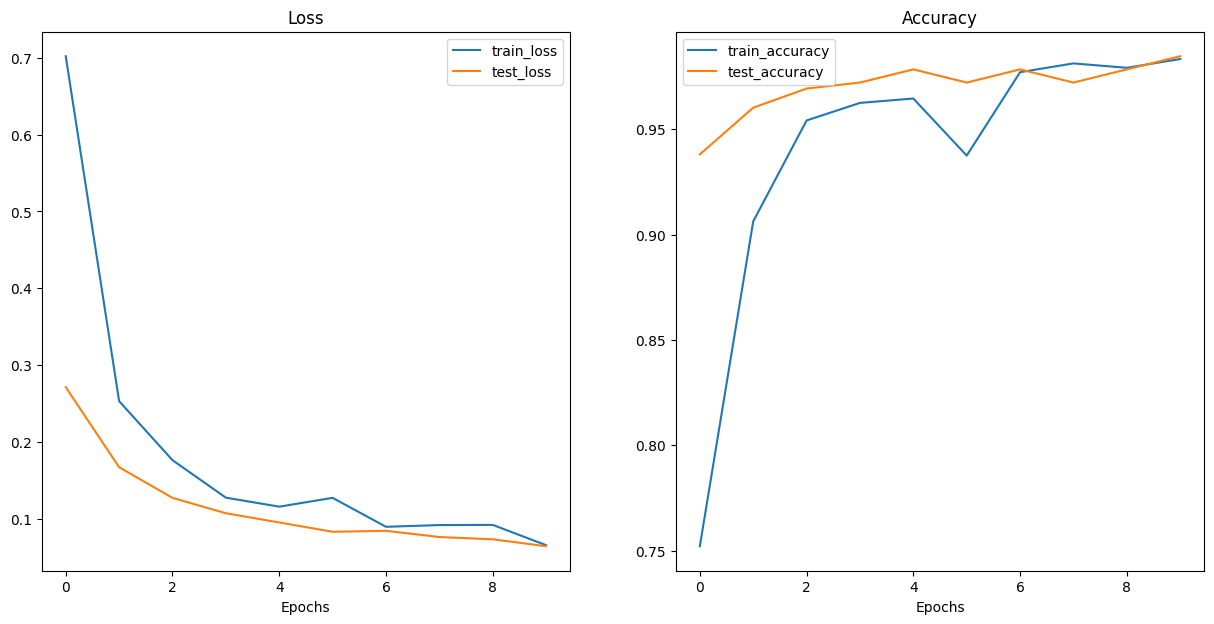

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results= pretrained_vit_results)

### 4.4 Saving ViT feature extractor

In [ ]:
from going_modular.going_modular import  utils

# Save the model
utils.save_model(model= vit,
                 target_dir = "models",
                 model_name = "09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [ ]:
from pathlib import Path

# Get the model size
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6  Collecting ViT feature extractor stats

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with ViT statistics
vit_stats = {"test_loss":pretrained_vit_results["test_loss"][-1],
                  "test_acc": pretrained_vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making preditions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (+30FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image.

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths


In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/476421.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/148765.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

Steps to create `pred_and_store()`

1. Create a function that takes a list of paths, a trained PyTorch, a series of transforms, a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop)
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground thruth class from the filepath.
6. Start the prediction timer
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` model.
10. Turn on `torch.inference_mode()` and past the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary form step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2..
15. Return the list of predictions dictionaries.

In [ ]:
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm
from PIL import Image
import pathlib
import torch


def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  # Empty list to store prediction dictionaries
  prediction_list = []

  # Loop through the target input paths
  for path in tqdm(paths):

    # Empty dictionary to store
    prediction_values = {}

    # Get sample path and ground truch class name
    prediction_values["image_path"] = path
    class_name = path.parent.stem
    prediction_values["class_name"] = class_name

    # Start the timer
    start_timer = timer()

    # Open the image using `Image.open(path)`
    img = Image.open(path)

    # Transform the image to be usable with a given model(also add a batch dimension)
    transform_image = transform(img).unsqueeze(0).to(device)

    # Prepare the model for inference
    model = model.to(device)
    model.eval()

    # Turn on inference model and pass the target transformed image
    with torch.inference_mode():
      pred_logit = model(transform_image)
      pred_prob = torch.softmax(pred_logit,dim=1) # turn logits into prediction probabilites
      pred_label = torch.argmax(pred_prob, dim=1) # turn pred_prob into prediction label
      pred_class = class_names[pred_label.cpu()] #hardcore prediction class to be on CPU

      # Add the predictions to the dictionary
      prediction_values["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      prediction_values["pred_class"]  = pred_class

      # End prediction timer
      end_timer = timer()
      prediction_values["time_for_pred"] = round(end_timer - start_timer, 4)

    # See if the predicted class matches the ground truth class
    prediction_values["correct"] = class_name == pred_class

    # Append the dictionary to the empty list of predicctions
    prediction_list.append(prediction_values)

  # Return the prediction list
  return prediction_list


### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcore our predictions  to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropiate transforms (e.g EffNetbB2 with `effnetb2_transforms`)

In [ ]:
# Make predictions across test dataset with EffNetB2
effnet_b2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                           model = effnet_b2,
                                           transform = effnetb2_transforms,
                                           class_names = class_names,
                                           device = "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnet_b2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9184,
  'pred_class': 'pizza',
  'time_for_pred': 0.2874,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9468,
  'pred_class': 'pizza',
  'time_for_pred': 0.1101,
  'correct': True}]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnet_b2_test_pred_df = pd.DataFrame(effnet_b2_test_pred_dicts)
effnet_b2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9184,pizza,0.2874,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9468,pizza,0.1101,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.6586,pizza,0.1032,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9312,pizza,0.1214,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.7100,pizza,0.1390,True


In [ ]:
# Check number of correct predictions
effnet_b2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
# Find the average time per prediction
effnet_b2_average_time_per_pred = round(effnet_b2_test_pred_df.time_for_pred.mean(),4)
print(f"EffNetB2 average time per prediction: {effnet_b2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.1048


> **Note:** Predictions times will vary (much like training times) depending on the hardware you're using... so generally the faster your compute (e.g. CPU or GPU), the faster the predictions will happen.

In [ ]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = float(effnet_b2_average_time_per_pred)
effnetb2_stats

{'test_loss': 0.2810868382453918,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8607120513916,
 'time_per_pred_cpu': 0.1048}

### 5.3 Making and timing predicions with ViT

In [ ]:
# Make predictions with ViT
vit_pred_dicts = pred_and_store(paths = test_data_paths,
                                model= vit,
                                transform=vit_transforms,
                                class_names=class_names,
                                device = "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9989,
  'pred_class': 'pizza',
  'time_for_pred': 0.5594,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9983,
  'pred_class': 'pizza',
  'time_for_pred': 0.355,
  'correct': True}]

In [ ]:
# Turn it into a dataframe
vit_pred_df = pd.DataFrame(vit_pred_dicts)
vit_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9989,pizza,0.5594,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9983,pizza,0.3550,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9877,pizza,0.3537,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9984,pizza,0.3642,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9990,pizza,0.3607,True


In [ ]:
# Check number of correct predictions
vit_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Find the average time per prediction
vit_average_time_per_pred = round(vit_pred_df.time_for_pred.mean(),4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.3834


In [ ]:
# Add average time per prediction to ViT stast
vit_stats["time_per_pred_cpu"] = float(vit_average_time_per_pred)
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.3834}

## 6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add a column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df ["test_acc"] = round(df["test_acc"] * 100,2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.860712,0.1048,EffNetB2
1,0.064435,98.47,85800963,327.000000,0.3834,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * *sometimes models with higher parameters can still perfom fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` - (lower is better, will be highly dependent of the hardware you're running on) - EffNetB2

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 ans see how it goes

In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data = (df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns = ["Vit to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
Vit to EffNetB2 ratios,0.229233,1.023065,11.135432,10.950844,3.658397


### 6.1 Visualizing the speed vs.performance tradeoff

So we've compared our EffNetB2 and ViT features extractor models, now let's visualize the comparison with a speed vs. performance plot

We can do so with matplotlib:
1. Create a scatter plot from the comparion DataFrame to compare EffNetB2 and ViT across test accurarcy and prediction time.
2. Add titles and label to make our plot look nice.
3. Anotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

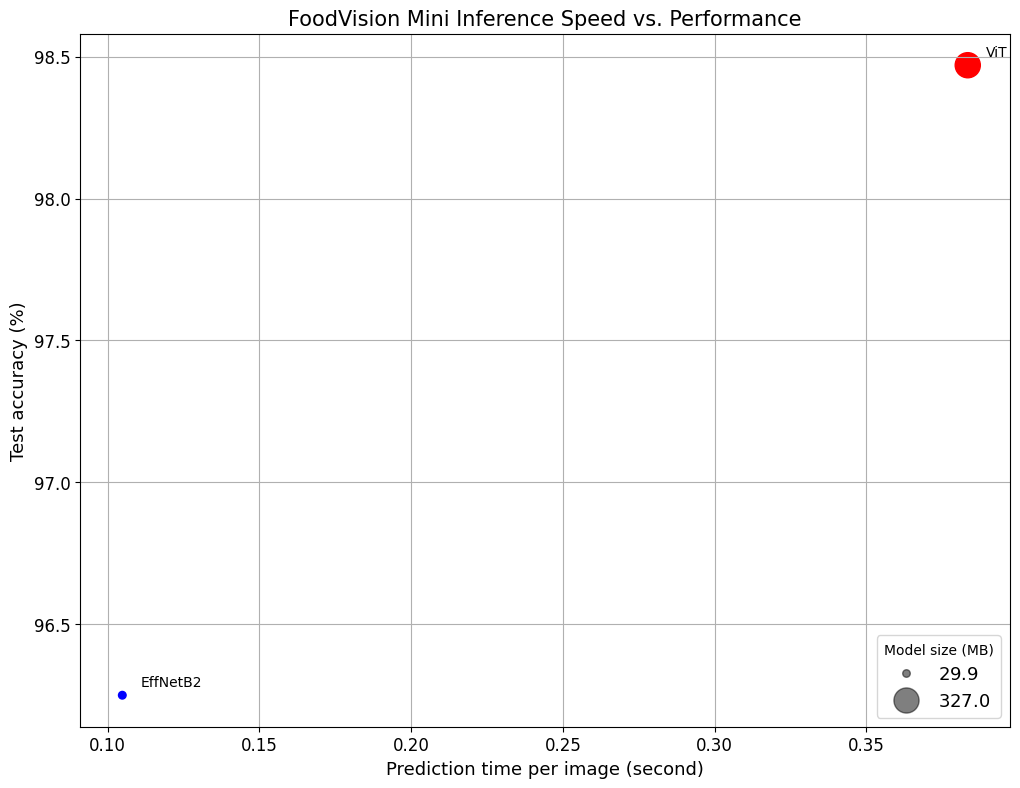

In [ ]:
import matplotlib.pyplot as plt

# 1. Create a plot from model comparison DataFrame
fig,ax = plt.subplots(figsize=(12,9))
scatter = ax.scatter(data = df,
                     x="time_per_pred_cpu",
                     y = "test_acc",
                     c = ["blue", "red"],
                     s = "model_size (MB)")

# 2. Add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs. Performance", fontsize = 15)
ax.set_xlabel("Prediction time per image (second)", fontsize = 13)
ax.set_ylabel("Test accuracy (%)", fontsize = 13)
ax.tick_params(axis= "both", labelsize=12)
ax.grid(True)

# 3. Anotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy = (row["time_per_pred_cpu"]+0.006, row["test_acc"]+0.03))

  #4. Create a legend based on the model sizes (model_size (MB))
  handles, labels = scatter.legend_elements(prop="sizes", alpha = 0.5)
  model_size_legend = ax.legend(handles,
                                labels, loc = "lower right",
                                title = "Model size (MB)",
                                fontsize = 13)

  # Save the figure
  plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?
> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://www.gradio.app/

In [ ]:
pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


### 7.1 Gradio overview

Gradio helps you create a ML demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployement is as important as training.

The overall premise of Gradio is to map inputs -> function/model -> outputs

### 7.2 Creating a function to map our inputs and outputs

In [ ]:
# Put our model on the CPU
effnet_b2 = effnet_b2.to("cpu")

# Check the device
next(iter(effnet_b2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label and prediction time)
```

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Tranform the input image for use with EffNetB2and add a batch dimension
  img = effnet_b2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make prediction
  effnet_b2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilites
    pred_probs = torch.softmax(effnet_b2(img), dim =1)

  # Create a prediction label, and prediction probability dictionary
  pred_labels_and_probs= {class_names[i]: float(pred_probs[0][i]) for i in range (len (class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)


  # Retunr pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img = image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image path: data/pizza_steak_sushi_20_percent/test/sushi/3177743.jpg

{'pizza': 0.06542330235242844, 'steak': 0.10280870646238327, 'sushi': 0.8317679762840271}
0.1193


### 7.3 Creating a list of example images

The examples for Gradio can be creted with the `examples` parameter, see here: https://www.gradio.app/guides/quickstart#building-your-first-demo

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> tranform -> predict with EffNetB2 -> output: pred_ prob, prob_time
```

In [ ]:
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = " An [EffNetB2 feature extractor](https://docs.pytorch.org/vision/0.21/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) computer vision model to classify images as pizza, steak or sushi"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)"

demo = gr.Interface(
    fn = predict, # function we want to use
    inputs =gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes = 3, label = "Predictions"),
        gr.Number(label = "Prediction time (s)")],
    examples = example_list,
    title = title,
    description = description,
    article = article

)

# Launch the demo
demo.launch(debug = False,
            share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0965d2149fc7e11b77.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

Our Gradio demos from Google Colab are fantastic but they expired within 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces: https://huggingface.co/spaces

### 8.1 What is Hugging Face Spaces

>Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or your organization’s profile. This allows you to create your ML portfolio, showcase your projects at conferences or to stakeholders, and work collaboratively with other people in the ML ecosystem.

If GitHub is a place to show your coding ability, Hugging Face Spaces is a place to show your machine learning ability (through sharing ML demos that you've built).

### 8.2 Deploy Gradio app structure

Let's start to put all our app files into a single directory:

```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```
By the end our file structure will look like this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this structure?

Because it's one of the simplest we could start with.

### 8.3 Creating a `demos` folder to store our FoodVision app files

In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents= True,
                                  exist_ok = True)
else:
  foodvision_mini_demo_path.mkdir(parents= True,
                                  exist_ok = True)
!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set

In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_demo_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_demo_examples_path.mkdir(parents = True,
                                          exist_ok=True)
# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three random images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_demo_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src= example,
               dst = destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_demo_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "/content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth"
# Create a destination path for our target model
effnet_b2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnet_b2_foodvision_mini_model_destination}")

  # Move the model
  shutil.move(src = effnetb2_foodvision_mini_model_path,
               dst = effnet_b2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")

except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnet_b2_foodvision_mini_model_destination}: {effnet_b2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move /content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/content
[INFO] Model move complete.


### 8.6 Turning off EffNet model into a Pyton script (`model.py`)

We have a save `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnet_b2_model(num_classes: int = 3,
                           seed: int = 42):
  """
  Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.

  """

  # 1. Setup pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

  # 2.Get transforms
  transforms = weights.transforms()

  # 3. Cretate the pretrained model
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the base layer
  for param in model.parameters():
    param.requires_grad = False

  # 5. Update the classifier head to suit our data with reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features= num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Pyton scrip (`app.py`)

The `app.py` file will have four major parts:
1. Import and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [ ]:
%%writefile demos/foodvision_mini/app.py

### 1. Import and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnet_b2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]


### 2. Model and transforms preparation ###

effnet_b2, effnet_b2_transforms = create_effnet_b2_model(
    num_classes= len(class_names))

# Load save weights
effnet_b2.load_state_dict(
    torch.load(f"09_pretrained_effnetb2_feature_extractor_steak_sushi_20_percent.pth",
               map_location = torch.device("cpu"))
)


### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Tranform the input image for use with EffNetB2and add a batch dimension
  img = effnet_b2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make prediction
  effnet_b2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilites
    pred_probs = torch.softmax(effnet_b2(img), dim =1)

  # Create a prediction label, and prediction probability dictionary
  pred_labels_and_probs= {class_names[i]: float(pred_probs[0][i]) for i in range (len (class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)


  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = " An [EffNetB2 feature extractor](https://docs.pytorch.org/vision/0.21/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) computer vision model to classify images as pizza, steak or sushi"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)"

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(
    fn = predict, # function we want to use
    inputs =gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes = 3, label = "Predictions"),
        gr.Number(label = "Prediction time (s)")],
    examples = example_list,
    title = title,
    description = description,
    article = article

)

# Launch the demo
demo.launch(debug = False,
            share = True)

Writing demos/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

* torch
* torchvision
* gradio

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt

torch >= 2.0.0
torchvision >= 0.15.0
gradio >= 4.0.0

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces


### 9.1 Downloading our FoodVision Mini app files

We want to download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces

In [ ]:
!ls demos/foodvision_mini

09-foodvision-mini-inference-speed-vs-performance.png  helper_functions.py
app.py						       model.py
examples					       requirements.txt


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09-foodvision-mini-inference-speed-vs-performance.png (deflated 24%)
  adding: 09_pretrained_effnetb2_feature_extractor_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: helper_functions.py (deflated 65%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 19%)


In [ ]:
# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Running our Gradio demo app locally

Running the app locally - https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

See the steps here - https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

## 10. Creating FoodVision Big

FoodVision Mini workds well with 3 classes (pizza, steak, sushi).

So all of experiment is paying off...

Let's steps things up a notch and make FoodVision Big!!! usigin all of the Food101 classes.


### 10.1 Creating a model for FoodVision Big + transforms

In [4]:
effnetb2_food101, effnetb2_transforms =  create_effnet_b2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 129MB/s]


Since we're working with a larger dataset, we may want to introduce some data agumentation techniques:
* This is because with a larger datasets and larger models, overfitting becomes more of a problem
* Because we're working with a large number of classes, let's use TrivialAugment as our data augmentation technique



In [5]:
#Creating training data transforms
food_101_transforms = torchvision.transforms.Compose ([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

food_101_transforms


Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [6]:
# Testing dta transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

In [7]:
from torchvision import datasets
from pathlib import Path

data_dir = Path("data")

# Get training data
train_data = datasets.Food101(root = data_dir,
                              split = "train",
                              transform = food_101_transforms,
                              download = True)

# Get testind data
test_data = datasets.Food101(root=data_dir,
                             split = "test",
                             transform = effnetb2_transforms,
                             download = True)

100%|██████████| 5.00G/5.00G [03:39<00:00, 22.8MB/s]


In [8]:
# Gett Food101 class names
food_101_class_names = train_data.classes
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from Food101 dataset (training and test).

Our short-term goal: to veat the origianl Food101 paper results of 56.40% accuracy on the test dataset

We want to beat this result using modern deep learning techiniques and only 20% of the data

In [9]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size: float = 0.2,
                  seed: int = 42):

  # Create split lengths based on the original dataset lenght
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths = [length_1, length_2],
                                                                 generator = torch.manual_seed(seed))
  return random_split_1, random_split_2


In [10]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset= train_data,
                                                 split_size = 0.2)

#Create testing 20% split
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size = 0.2)


[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


### 10.4 Turning our Food101 dataset into `DataLoaders`

In [11]:
import os
BATCH_SIZE = 32

# Create training and testing Dataloaders
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = True)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = False)

### 10.5 Training FoodVision Big!!!

Things for training:
* 5 epochs
* Optmizer: `torch.optim.Adam(lr = 1e-3)`
* Loss function: `torch.nn.CrossEntropyLoss(label_smoothing = 0.1)`

Why use label smoothing?

Label smoothing helps to prevent overfitting (it's a regularization technique).

Without label smoothing and 5 classes:
```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:
```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [12]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6408 | train_acc: 0.2785 | test_loss: 2.7887 | test_acc: 0.4891
Epoch: 2 | train_loss: 2.8632 | train_acc: 0.4435 | test_loss: 2.4761 | test_acc: 0.5332
Epoch: 3 | train_loss: 2.6622 | train_acc: 0.4828 | test_loss: 2.3554 | test_acc: 0.5548
Epoch: 4 | train_loss: 2.5487 | train_acc: 0.5096 | test_loss: 2.3047 | test_acc: 0.5724
Epoch: 5 | train_loss: 2.4890 | train_acc: 0.5267 | test_loss: 2.2743 | test_acc: 0.5773


### 10.6 Inspecting loss curves of FoodVision Big model

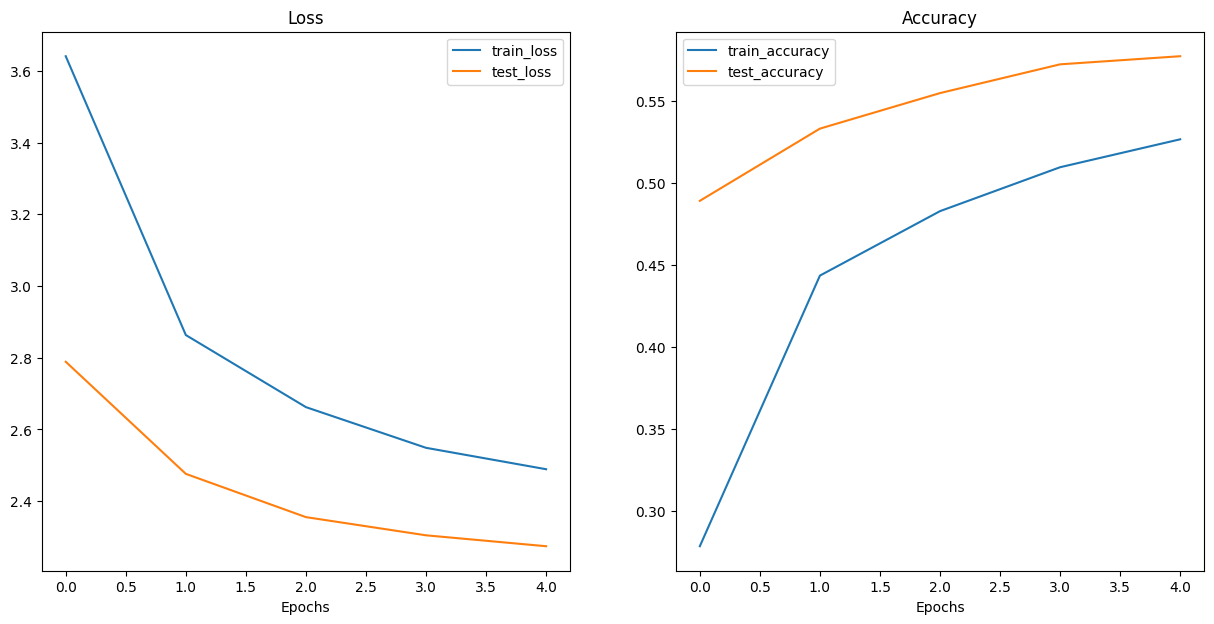

In [13]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

In [14]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


## 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set)

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```




In [15]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big")

# Make FoodVision big directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok = True)

# Make FoodVision Big demo examples diretory
(foodvision_big_demo_path/ "examples").mkdir(parents=True,
                                             exist_ok=True)

In [16]:
!ls demos/foodvision_big/

examples


### 11.1 Downloading example image and moving it to the `examples` directory

In [17]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2025-06-03 07:50:09--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2025-06-03 07:50:10 (55.0 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)

Let' save all of the Food101 names to a .txt file so ve can import them and use them in our app

In [19]:
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [18]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [20]:
# Write Food101 class to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f'[INFO] Saving Food101 class to {foodvision_big_class_names_path}')
  f.write("\n".join(food_101_class_names))

[INFO] Saving Food101 class to demos/foodvision_big/class_names.txt


In [23]:
# Open Food101 class names file and read each file into a list
with open(foodvision_big_class_names_path, "r") as f:
  food_101_class_names_loaded = [food.strip() for food in f.readlines()]

food_101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [24]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script(`app.py`)

This will again mostly be the same as the FoodVision Mini app.py script except we'll change:

1. **Imports and class names setup** - The class_names variable will be a list for all of the Food101 classes rather than pizza, steak, sushi. We can access these via `demos/foodvision_big/class_names.txt`.
2. **Model and transforms preparation** - The `model` will have `num_classes=101` rather than `num_classes=3`. We'll also be sure to load the weights from `"09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"` (our FoodVision Big model path).
3. **Predict function** - This will stay the same as FoodVision Mini's `app.py`.
4. **Gradio app** - The Gradio interface will have different `title`, `description` and `article` parameters to reflect the details of FoodVision Big.

In [26]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food.strip() for food in f.readlines()]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    len(class_names), # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt). "
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=4, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/foodvision_big/app.py


### 11.5 Requirements file for FoodVision Big (`requirements.txt`)

In [27]:
%%writefile demos/foodvision_big/requirements.txt

torch >= 2.0.0
torchvision >= 0.15.0
gradio >= 4.0.0

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading our FoodVision Big app files

In [28]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 19%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12. FoodVisionBig really Big

### 12.1 Creating a model and transforms for FoodVision Big

In [34]:
effnetb2_food101, effnetb2_transforms =  create_effnet_b2_model(num_classes=101)

In [35]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [36]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### 12.2 Getting data

In [37]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

In [38]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 12.3 Turning our Food datasets into `DataLoaders`

In [39]:
import os
import torch

BATCH_SIZE = 32

# Create Food101 training DataLoader
train_dataloader_food101 = torch.utils.data.DataLoader(train_data,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True)
# Create Food101 testing DataLoader
test_dataloader_food101 = torch.utils.data.DataLoader(test_data,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False)

### 12.4 Training FoodVision Big

In [40]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes


effnetb2_food101 = effnetb2_food101.to(device)
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101,
                                        test_dataloader=test_dataloader_food101,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9837 | train_acc: 0.4071 | test_loss: 2.1803 | test_acc: 0.6085
Epoch: 2 | train_loss: 2.6506 | train_acc: 0.4793 | test_loss: 2.1025 | test_acc: 0.6328
Epoch: 3 | train_loss: 2.6205 | train_acc: 0.4900 | test_loss: 2.0764 | test_acc: 0.6351
Epoch: 4 | train_loss: 2.6063 | train_acc: 0.4930 | test_loss: 2.0485 | test_acc: 0.6473
Epoch: 5 | train_loss: 2.5975 | train_acc: 0.4986 | test_loss: 2.0514 | test_acc: 0.6443


### 12.5 Inspecting loss curves of FoodVision Big

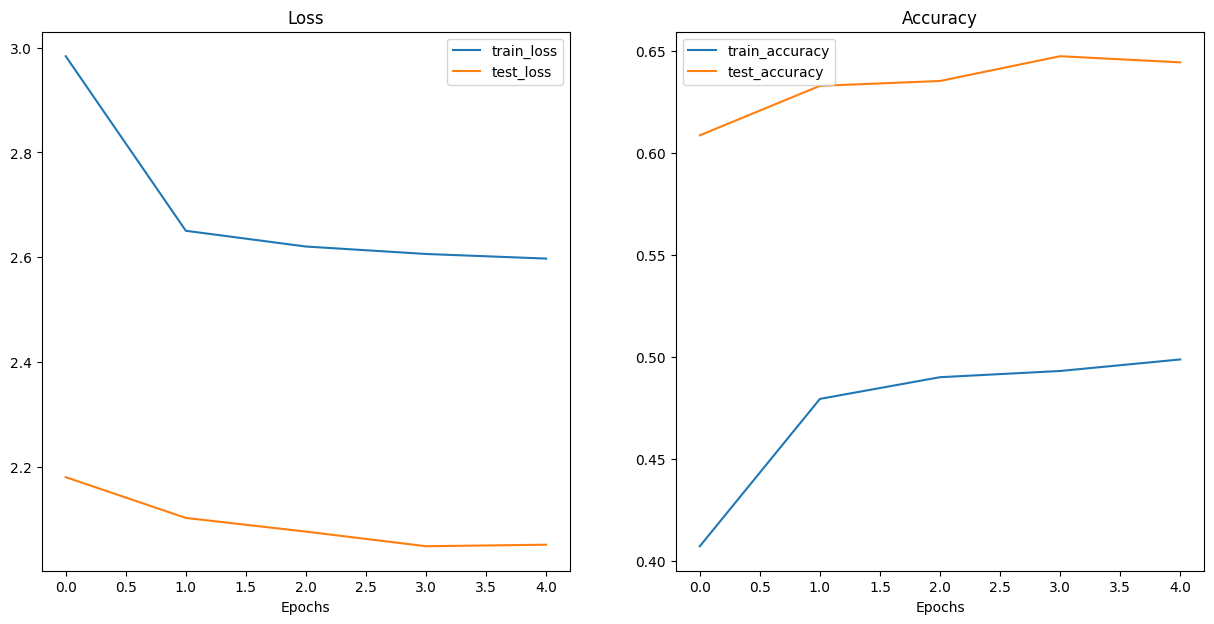

In [41]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

### 12.6 Saving and loading FoodVision Big

In [42]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path_big = "09_pretrained_effnetb2_feature_extractor_food101.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path_big)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101.pth


### 12.7 Checking FoodVision Big model size

In [43]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path_big).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 13. Turning our FoodVision Big model into a deployable app

In [44]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path_total = Path("demos/foodvision_big_total/")

# Make FoodVision Big demo directory
foodvision_big_demo_path_total.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path_total / "examples").mkdir(parents=True, exist_ok=True)

In [45]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big_total/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101.pth demos/foodvision_big_total

--2025-06-03 11:31:44--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2025-06-03 11:31:44 (56.9 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 13.2 Saving Food101 class names to file(`class_names.txt)

In [46]:
# Create path to Food101 class names
foodvision_big_class_names_path_total = foodvision_big_demo_path_total / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path_total, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path_total}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big_total/class_names.txt


### 13.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [47]:
%%writefile demos/foodvision_big_total/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big_total/model.py


### 13.4 Turning our FoodVision Big Gradio app into a Pythonn scipt (`app.py`)

In [2]:
%%writefile demos/foodvision_big_total/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
).to(device)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101.pth",
        map_location=device,
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0).to(device)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big_total/app.py


FileNotFoundError: [Errno 2] No such file or directory: 'demos/foodvision_big_total/app.py'

### 13.5 Creating a requirements (`requirements.txt`)

In [49]:
%%writefile demos/foodvision_big_total/requirements.txt
torch >= 2.0.0
torchvision >= 0.15.0
gradio >= 4.0.0


Writing demos/foodvision_big_total/requirements.txt


### 13.6 Downloading our FoodVision Big app files

In [51]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big_total && zip -r ../foodvision_big_total.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big_total.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: 09_pretrained_effnetb2_feature_extractor_food101.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 17%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import torch

# 1. Create the model again
effnetb2, _ = create_effnet_b2_model(num_classes=101)

# 2. Load your already-trained weights
effnetb2.load_state_dict(torch.load("09_pretrained_effnetb2_feature_extractor_food101.pth", map_location="cpu"))

# 3. Set to eval mode (so it doesn't do training things)
effnetb2.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:


# 1. Create the model again
effnetb2, _ = create_effnet_b2_model(num_classes=101)

# 2. Load your already-trained weights
effnetb2.load_state_dict(torch.load("09_pretrained_effnetb2_feature_extractor_food101.pth", map_location="cpu"))

# 3. Set to eval mode (so it doesn't do training things)
effnetb2.eval()

# 4. Make dummy input
dummy_input = torch.randn(1, 3, 224, 224)

# 5. Trace model
traced_model = torch.jit.trace(effnetb2, dummy_input)

# 6. Save traced model
traced_model.save("effnetb2_traced_food101.pt")
